# 02_CNN — Autenticación de huellas con CNN

### Este notebook asume que ya se ejecutó 00_preprocessing.ipynb, que generó:
###    data/train/authenticated, data/train/rejected
###    data/test/authenticated, data/test/rejected

## 1) Imports y dispositivo

In [69]:
import os, numpy as np, torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
from sklearn.metrics import f1_score, roc_curve, auc
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from collections import Counter
import random
from torchvision.transforms import RandomAutocontrast, RandomAdjustSharpness, GaussianBlur
import torch.backends.cudnn as cudnn


# reproducibilidad
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

Device: cpu


## 2) Paths y parámetros

In [70]:
DATA_DIR   = '../data'
TRAIN_DIR  = os.path.join(DATA_DIR, 'train')
TEST_DIR   = os.path.join(DATA_DIR,  'test')

# hiperparámetros
IMG_SIZE   = 224
BATCH_SIZE = 16
EPOCHS     = 100
LR         = 5e-4          
WEIGHT_DECAY = 1e-5
PATIENCE   = 10            

## 3) Dataset y DataLoaders
Etiquetas: authenticated → 0, rejected → 1

In [71]:
train_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomRotation(20),
    transforms.RandomAffine(degrees=0, translate=(0.1,0.1), scale=(0.9,1.1)),
    transforms.RandomPerspective(distortion_scale=0.15, p=0.25),
    RandomAutocontrast(p=0.3),
    RandomAdjustSharpness(sharpness_factor=1.5, p=0.3),
    GaussianBlur(kernel_size=3),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

test_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

class FingerprintDataset(Dataset):
    def __init__(self, root_dir, transform):
        self.transform = transform
        self.samples = []
        label_map = {'authenticated':0, 'rejected':1}
        for sub in ('authenticated','rejected'):
            d = os.path.join(root_dir, sub)
            if not os.path.isdir(d): continue
            for fn in os.listdir(d):
                if fn.lower().endswith('.png'):
                    self.samples.append((os.path.join(d, fn), label_map[sub]))
    def __len__(self): return len(self.samples)
    def __getitem__(self, idx):
        path, y = self.samples[idx]
        x = Image.open(path).convert('L')
        x = self.transform(x)
        return x, torch.tensor(y, dtype=torch.float32)

class FingerprintDatasetFromList(Dataset):
    def __init__(self, samples, transform):
        self.samples = list(samples)          
        self.transform = transform
    def __len__(self):
        return len(self.samples)
    def __getitem__(self, i):
        path, y = self.samples[i]
        x = Image.open(path).convert('L')
        x = self.transform(x)
        return x, torch.tensor(y, dtype=torch.float32)

base = FingerprintDataset(TRAIN_DIR, transform=test_transform)  

samples = base.samples  # [(path,label)]
y_all = [y for _,y in samples]

from sklearn.model_selection import train_test_split
idx_tr, idx_val = train_test_split(
    np.arange(len(samples)), test_size=0.2, random_state=SEED, stratify=y_all, shuffle=True
)

train_samples = [samples[i] for i in idx_tr]
val_samples   = [samples[i] for i in idx_val]

train_ds = FingerprintDatasetFromList(train_samples, transform=train_transform)  # CON augment
val_ds   = FingerprintDatasetFromList(val_samples,   transform=test_transform)   # SIN augment
test_ds  = FingerprintDataset(TEST_DIR, transform=test_transform)

from torch.utils.data import DataLoader
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False)


## 4) Modelo

In [72]:
class FingerprintCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1, 1),   nn.BatchNorm2d(32),   nn.LeakyReLU(0.1), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, 1, 1),  nn.BatchNorm2d(64),   nn.LeakyReLU(0.1), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, 1, 1), nn.BatchNorm2d(128),  nn.LeakyReLU(0.1), nn.MaxPool2d(2),
            nn.Conv2d(128,256, 3, 1, 1), nn.BatchNorm2d(256),  nn.LeakyReLU(0.1), nn.MaxPool2d(2),
            nn.Conv2d(256,384, 3, 1, 1), nn.BatchNorm2d(384),  nn.LeakyReLU(0.1),
            nn.AdaptiveAvgPool2d((7,7))   
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(384*7*7, 512), nn.BatchNorm1d(512), nn.LeakyReLU(0.1), nn.Dropout(0.5),
            nn.Linear(512, 256),     nn.BatchNorm1d(256), nn.LeakyReLU(0.1), nn.Dropout(0.5),
            nn.Linear(256, 1)  
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)      
        return x

model = FingerprintCNN().to(device)

# pérdida con logits 
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=4)


## 5) Entrenamiento (con early stopping)

In [73]:
cudnn.deterministic = True
cudnn.benchmark = False

best_val = float('inf'); wait = 0
max_grad_norm = 1.0  # opcional: estabilidad

for epoch in range(1, EPOCHS+1):
    # ---- train ----
    model.train(); tr_loss = 0.0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        logits = model(x).squeeze(1)              
        loss = criterion(logits, y)               
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)  # opcional
        optimizer.step()
        tr_loss += loss.item()
    tr_loss /= max(1, len(train_loader))

    # ---- validation ----
    model.eval(); va_loss = 0.0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            logits = model(x).squeeze(1)
            va_loss += criterion(logits, y).item()
    va_loss /= max(1, len(val_loader))
    scheduler.step(va_loss)

    print(f"Epoch {epoch:03d} | train: {tr_loss:.4f} | val: {va_loss:.4f}")

    if va_loss < best_val:
        best_val, wait = va_loss, 0
        torch.save(model.state_dict(), 'FingerprintCNN_best.pt')
    else:
        wait += 1
        if wait >= PATIENCE:
            print("Early stopping!")
            break

model.load_state_dict(torch.load('FingerprintCNN_best.pt', map_location=device))
model.eval()


Epoch 001 | train: 0.4772 | val: 0.1743
Epoch 002 | train: 0.2336 | val: 0.0402
Epoch 003 | train: 0.1651 | val: 0.1160
Epoch 004 | train: 0.1086 | val: 0.0166
Epoch 005 | train: 0.1106 | val: 0.0592
Epoch 006 | train: 0.0766 | val: 1.1805
Epoch 007 | train: 0.1394 | val: 0.0187
Epoch 008 | train: 0.0883 | val: 0.0054
Epoch 009 | train: 0.0673 | val: 0.0410
Epoch 010 | train: 0.0956 | val: 0.0136
Epoch 011 | train: 0.0416 | val: 0.0497
Epoch 012 | train: 0.0826 | val: 0.0008
Epoch 013 | train: 0.0349 | val: 0.0027
Epoch 014 | train: 0.0522 | val: 0.0003
Epoch 015 | train: 0.0265 | val: 0.0180
Epoch 016 | train: 0.0456 | val: 0.0076
Epoch 017 | train: 0.0562 | val: 0.0073
Epoch 018 | train: 0.0425 | val: 0.0000
Epoch 019 | train: 0.0549 | val: 0.0004
Epoch 020 | train: 0.0339 | val: 0.0062
Epoch 021 | train: 0.0421 | val: 0.0002
Epoch 022 | train: 0.0193 | val: 0.0034
Epoch 023 | train: 0.0313 | val: 0.4285
Epoch 024 | train: 0.0349 | val: 0.0005
Epoch 025 | train: 0.0211 | val: 0.0001


FingerprintCNN(
  (conv): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.1)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.1)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2

## 6) Buscar threshold óptimo en validación (max F1)

In [74]:
# recogemos probs y labels de validación con el mejor modelo
val_probs, val_labels = [], []
with torch.no_grad():
    for x,y in val_loader:
        x = x.to(device)
        p = model(x).squeeze(1)
        val_probs.extend(p.cpu().numpy())
        val_labels.extend(y.numpy())

val_probs = np.array(val_probs); val_labels = np.array(val_labels)

best_f1, best_thr = 0.0, 0.5
for thr in np.linspace(0.1, 0.9, 81):
    f1 = f1_score(val_labels, (val_probs >= thr).astype(int))
    if f1 > best_f1: best_f1, best_thr = f1, thr
print(f"Mejor F1 en validación = {best_f1:.3f} con threshold = {best_thr:.2f}")

THRESHOLD = float(best_thr)

Mejor F1 en validación = 1.000 con threshold = 0.10


## 7) Evaluación en test con THRESHOLD óptimo (y ROC/EER opcional)

Test | Acc: 50.00% | F1: 0.2857 | thr=0.10 | N=10
AUC: 0.360 | EER: 0.600 | Thr@EER: -5.452


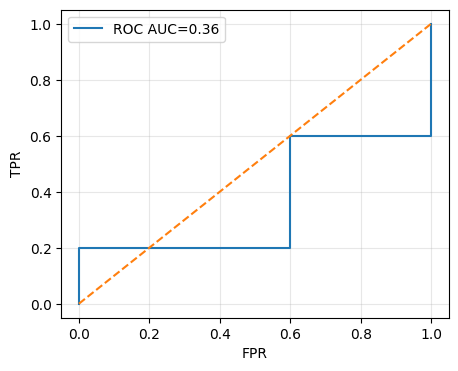

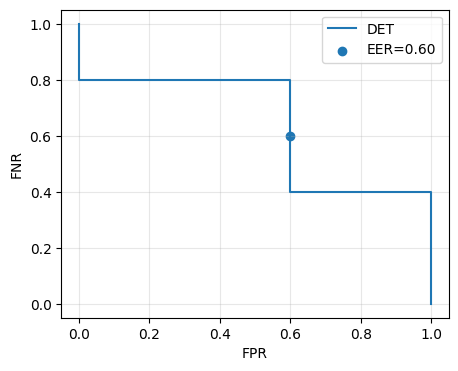

In [75]:
# probs/labels de test
test_probs, test_labels = [], []
with torch.no_grad():
    for x,y in test_loader:
        x = x.to(device)
        p = model(x).squeeze(1)
        test_probs.extend(p.cpu().numpy())
        test_labels.extend(y.numpy())

test_probs = np.array(test_probs); test_labels = np.array(test_labels)

# métricas @ threshold óptimo
y_pred = (test_probs >= THRESHOLD).astype(int)
acc = (y_pred == test_labels).mean() * 100
f1  = f1_score(test_labels, y_pred)

print(f"Test | Acc: {acc:.2f}% | F1: {f1:.4f} | thr={THRESHOLD:.2f} | N={len(test_labels)}")

# ROC / EER (opcional)
fpr, tpr, thr = roc_curve(test_labels, test_probs)
roc_auc = auc(fpr, tpr)
fnr = 1 - tpr
eer_idx = np.nanargmin(np.abs(fpr - fnr))
eer = fpr[eer_idx]; eer_thr = thr[eer_idx]
print(f"AUC: {roc_auc:.3f} | EER: {eer:.3f} | Thr@EER: {eer_thr:.3f}")

# plots rápidos
plt.figure(figsize=(5,4)); plt.plot(fpr,tpr,label=f'ROC AUC={roc_auc:.2f}')
plt.plot([0,1],[0,1],'--'); plt.xlabel('FPR'); plt.ylabel('TPR'); plt.legend(); plt.grid(alpha=.3); plt.show()

plt.figure(figsize=(5,4)); plt.plot(fpr, 1-tpr, label='DET'); plt.scatter([eer],[eer], label=f'EER={eer:.2f}')
plt.xlabel('FPR'); plt.ylabel('FNR'); plt.legend(); plt.grid(alpha=.3); plt.show()


## 8) Densidad de probabilidad

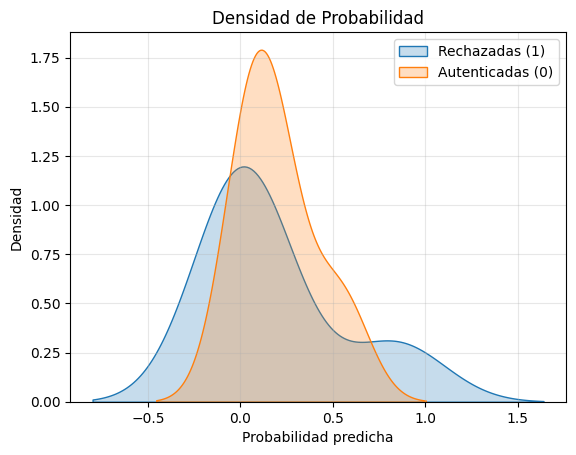

In [76]:
sns.kdeplot(np.array(all_probs)[np.array(all_labels)==1], label='Rechazadas (1)', fill=True)
sns.kdeplot(np.array(all_probs)[np.array(all_labels)==0], label='Autenticadas (0)', fill=True)
plt.title('Densidad de Probabilidad')
plt.xlabel('Probabilidad predicha'); plt.ylabel('Densidad')
plt.legend(); plt.grid(alpha=0.3); plt.show()

## 9) Visualización de un lote (pred vs real)

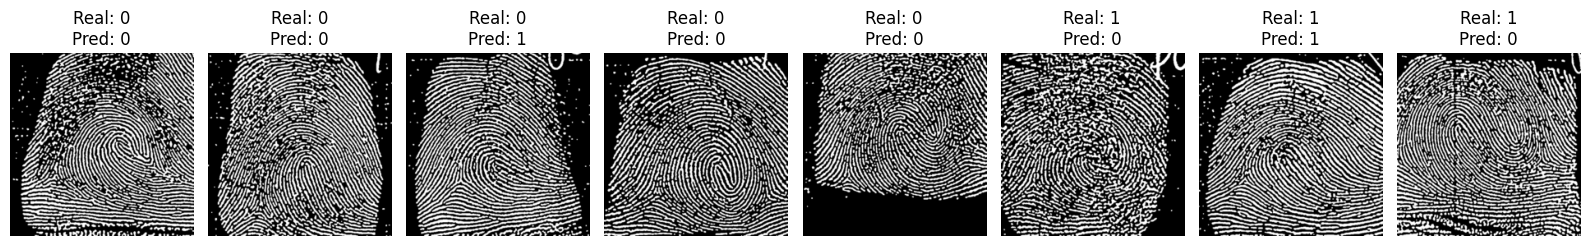

Etiquetas reales:  [0. 0. 0. 0. 0. 1. 1. 1.]
Etiquetas pred.:  [0. 0. 1. 0. 0. 0. 1. 0.]


In [77]:
model.eval()
images, labels = next(iter(test_loader)) # o train_loader si quieres ver entrenamiento
images, labels = images.to(device), labels.to(device)
with torch.no_grad():
    outputs = model(images).squeeze(1)
    predictions = (outputs >= THRESHOLD).float()

cols = min(8, images.size(0))
fig, axes = plt.subplots(1, cols, figsize=(2*cols, 3))
for i in range(cols):
    ax = axes[i]
    img = images[i].cpu().squeeze().numpy()
    ax.imshow(img, cmap='gray')
    ax.set_title(f"Real: {int(labels[i].item())}\nPred: {int(predictions[i].item())}")
    ax.axis('off')
plt.tight_layout(); plt.show()

print('Etiquetas reales: ', labels[:cols].cpu().numpy())
print('Etiquetas pred.: ', predictions[:cols].cpu().numpy())

## 10) Clasificar una huella nueva (flujo de autenticación)

In [79]:
def classify_fingerprint(model, image_path, transform, threshold=THRESHOLD):
    model.eval()
    image = Image.open(image_path).convert('L')
    x = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        logits = model(x).squeeze(1)
        prob = torch.sigmoid(logits).item()   
    return ('Authenticated' if prob > threshold else 'Rejected'), prob